In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF4500', '#808000'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='#4B0082')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000, precision = None):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.precision = precision
       
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
  
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def __initialize_parameters(self):
        hidden_layer_sizes = self.hidden_layer_sizes
        parameters = {}
        for l in range(1, len(hidden_layer_sizes)):
            parameters['W' + str(l)] = np.random.randn(hidden_layer_sizes[l], hidden_layer_sizes[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((hidden_layer_sizes[l], 1))
        self.parameters = parameters
             
    def __forward_linear_activation(self, A_prev, W, b):   
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
        A = self.__sigmoid(Z)
        activation_cache = Z
        cache = (linear_cache, activation_cache)
        return A, cache
    
    def __multilayer_forward(self, X):       
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2
        for l in range(1, L):
            A_prev = A 
            A, cache = self.__forward_linear_activation(A_prev, parameters["W"+str(l)], parameters["b"+str(l)])
            caches.append(cache)   
        AL, cache = self.__forward_linear_activation(A, parameters["W"+str(L)], parameters["b"+str(L)])
        caches.append(cache)
        assert(AL.shape == (1,X.shape[1]))
        return AL, caches
    
    def __backward_linear_activation(self, dA, cache):
        
        linear_cache, activation_cache = cache
        Z = activation_cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = 1 / m * np.dot(dZ, A_prev.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db

    def __multilayer_backward(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__backward_linear_activation(dAL, current_cache)
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__backward_linear_activation(grads["dA" + str(l + 1)], current_cache)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp  
        return grads
      
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
   
    def __update_parameters(self, grads):
        parameters = self.parameters;
        learning_rate = self.learning_rate
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]       
        self.parameters = parameters;
        
    
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        costs = []
        self.__initialize_parameters()
        for i in range(0, self.num_iter):
            AL, caches = self.__multilayer_forward(X)
            cost = self.compute_cost(AL, Y)
            grads = self.__multilayer_backward(AL, Y, caches) 
            self.__update_parameters(grads)
            if print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 1000 == 0:
                costs.append(cost) 
                if len(costs) > 1 and self.precision != None and np.abs(costs[-2] - costs[-1]) < self.precision:
                    print('Stopping gradient descent ...')
                    break
        if print_cost:
                plt.plot(costs)
                plt.ylabel("Cost")
                plt.xlabel("Iteration, *100")
                plt.show()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        probs = self.__multilayer_forward(X)[0]
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

# NeuralNet sats.csv

In [5]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


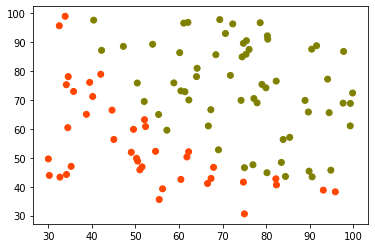

In [6]:
plot_data(X, Y)

In [7]:
#cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)
cls = NeuralNet(hidden_layer_sizes = [2,2,1], normalize = True, learning_rate = 0.5, num_iter = 20000) 

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

Cost after iteration 0: 0.693466
Cost after iteration 1000: 0.663453
Cost after iteration 2000: 0.509705
Cost after iteration 3000: 0.271147
Cost after iteration 4000: 0.227763
Cost after iteration 5000: 0.216820
Cost after iteration 6000: 0.213183
Cost after iteration 7000: 0.211714
Cost after iteration 8000: 0.210967
Cost after iteration 9000: 0.210478
Cost after iteration 10000: 0.210087
Cost after iteration 11000: 0.209741
Cost after iteration 12000: 0.209425
Cost after iteration 13000: 0.209132
Cost after iteration 14000: 0.208857
Cost after iteration 15000: 0.208595
Cost after iteration 16000: 0.208340
Cost after iteration 17000: 0.208078
Cost after iteration 18000: 0.207793
Cost after iteration 19000: 0.207453


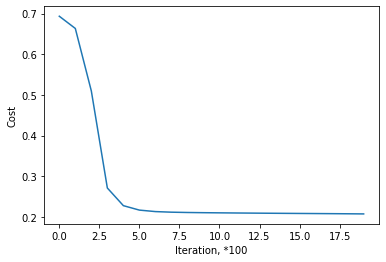

In [9]:
cls.fit(X_train, Y_train)

In [10]:
print(cls.parameters)

{'W1': array([[13.56990544,  9.3060709 ],
       [11.99915472, 10.43236782]]), 'b1': array([[1.01835404],
       [0.59025334]]), 'W2': array([[12.62298728, 12.41161852]]), 'b2': array([[-15.34553501]])}


In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.22560012e-02, 9.07743999e-01],
       [1.27902415e-04, 9.99872098e-01],
       [4.78495509e-02, 9.52150449e-01],
       [9.77775601e-01, 2.22243988e-02],
       [9.93193633e-01, 6.80636735e-03],
       [1.51950825e-02, 9.84804917e-01],
       [9.94332835e-01, 5.66716481e-03],
       [5.21358527e-01, 4.78641473e-01],
       [9.97321587e-01, 2.67841302e-03],
       [7.90087733e-01, 2.09912267e-01],
       [9.21302387e-01, 7.86976126e-02],
       [5.70343708e-02, 9.42965629e-01],
       [9.95922334e-01, 4.07766643e-03],
       [9.97968599e-01, 2.03140082e-03],
       [1.61551572e-01, 8.38448428e-01],
       [9.62307453e-01, 3.76925474e-02],
       [5.06025349e-01, 4.93974651e-01],
       [2.16539357e-01, 7.83460643e-01],
       [9.97213319e-01, 2.78668102e-03],
       [6.53363686e-01, 3.46636314e-01],
       [1.08466387e-01, 8.91533613e-01],
       [9.94561375e-01, 5.43862525e-03],
       [1.17628556e-02, 9.88237144e-01],
       [2.53598094e-04, 9.99746402e-01],
       [9.829309

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [13]:
accuracy_score(Y, Y_hat)

0.91

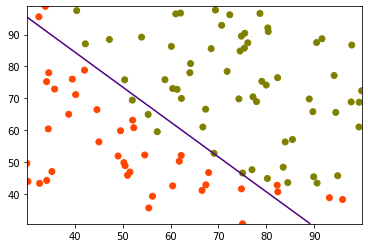

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 20000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=20000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

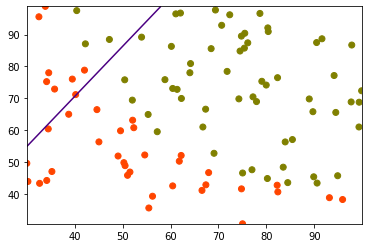

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.65

# NeuralNet tests.csv

In [19]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


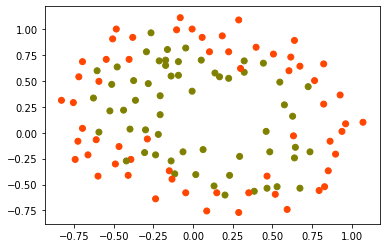

In [20]:
plot_data(X, Y)

In [21]:
#cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)
cls = NeuralNet(hidden_layer_sizes = [2,2,1], normalize = True, learning_rate = 0.5, num_iter = 20000) 

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

Cost after iteration 0: 0.693438
Cost after iteration 1000: 0.685292
Cost after iteration 2000: 0.652131
Cost after iteration 3000: 0.629653
Cost after iteration 4000: 0.595021
Cost after iteration 5000: 0.579446
Cost after iteration 6000: 0.571204
Cost after iteration 7000: 0.566119
Cost after iteration 8000: 0.562605
Cost after iteration 9000: 0.559970
Cost after iteration 10000: 0.557873
Cost after iteration 11000: 0.556133
Cost after iteration 12000: 0.554650
Cost after iteration 13000: 0.553365
Cost after iteration 14000: 0.552236
Cost after iteration 15000: 0.551234
Cost after iteration 16000: 0.550337
Cost after iteration 17000: 0.549525
Cost after iteration 18000: 0.548788
Cost after iteration 19000: 0.548112


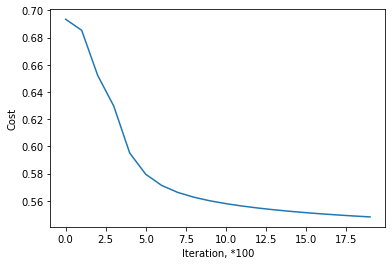

In [23]:
cls.fit(X_train, Y_train)

In [24]:
print(cls.parameters)

{'W1': array([[-2.47414207, -5.56205972],
       [-4.56646269,  0.37812171]]), 'b1': array([[15.74969831],
       [15.94159875]]), 'W2': array([[6.78593364, 6.58533603]]), 'b2': array([[-12.65635999]])}


In [25]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.669777  , 0.330223  ],
       [0.65400968, 0.34599032],
       [0.67148511, 0.32851489],
       [0.08624198, 0.91375802],
       [0.67148511, 0.32851489],
       [0.67148511, 0.32851489],
       [0.67148511, 0.32851489],
       [0.1315532 , 0.8684468 ],
       [0.65141922, 0.34858078],
       [0.67148511, 0.32851489],
       [0.67148467, 0.32851533],
       [0.67148511, 0.32851489],
       [0.33209977, 0.66790023],
       [0.07130846, 0.92869154],
       [0.6714851 , 0.3285149 ],
       [0.64546254, 0.35453746],
       [0.6714851 , 0.3285149 ],
       [0.64078541, 0.35921459],
       [0.67148485, 0.32851515],
       [0.67140682, 0.32859318],
       [0.67135844, 0.32864156],
       [0.67148511, 0.32851489],
       [0.67148511, 0.32851489],
       [0.01442968, 0.98557032],
       [0.67148354, 0.32851646],
       [0.65939168, 0.34060832],
       [0.67148511, 0.32851489],
       [0.65654782, 0.34345218],
       [0.6714809 , 0.3285191 ],
       [0.67146962, 0.32853038],
       [0.

In [26]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1])

In [27]:
accuracy_score(Y, Y_hat)

0.6779661016949152

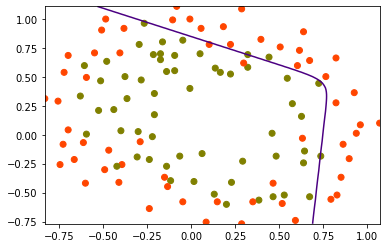

In [28]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [29]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [30]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

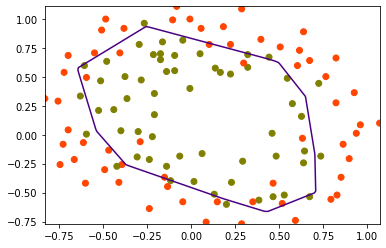

In [31]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [32]:
accuracy_score(Y, clf.predict(X))

0.8305084745762712